# Pset 3: What are twitter users in a 25mile radius around Boston tweeting about on Monday, March 7, 2017? 

In this exercise, I will scrape data from the Twitter using the Twitter REST API and the python library, Twython. 

In [1]:
# Import libraries
import json
import time
import threading
from datetime import datetime
from twython import Twython

# Imports the keys from the python file
# Keys saved locally 
import sys 
import os
sys.path.append(os.path.abspath("/Users/Emily/Documents/github/"))

from twitter_key import api_key, api_secret

In [2]:
# Assigns the keys to the variables
APP_KEY = api_key
APP_SECRET = api_secret

# Create a Twython object called Twitter
# Set this up using your Twitter Keys
# Say we are going to use OAuth 2
twython_setup = Twython(APP_KEY, APP_SECRET, oauth_version=2)

# Get an OAuth2 access token, save as variable so we can launch our 
OAUTH2_ACCESS_TOKEN = twython_setup.obtain_access_token()

# Create a Twython Object we will use for our access to the API
my_twython = Twython(APP_KEY, access_token=OAUTH2_ACCESS_TOKEN)

In [ ]:
# Input the search term you want to search on
search_term='' # SET A SEARCH TERM LIKE 'TRUMP'
# CAN LEAVE search_term BLANK IF YOU WANT ALL TWEETS NEAR A SPECIFIC LOCATION
# Setup a Lat Lon
latlong=[42.354072, -71.065815] # Downtown Boston (Boston Common)
# Setup a search distance
distance='25mi'
# Set result type (can be 'recent', 'popular', or 'mixed')
type_of_result='recent'
# Set number of results (up to 100, remember you can only get 450 in 15 minutes)
number_of_tweets=30


# Fetches tweets with a given query at a given lat-long.
def get_tweets_by_location( latlong=None ):
    # Uses the search function to hit the APIs endpoints and look for recent tweets within the area
    results = my_twython.search(q=search_term, geocode=str(latlong[0])+','+str(latlong[1])+','+ distance, result_type=type_of_result, count=number_of_tweets)
    # Returns the only the statuses from the resulting JSON
    return results['statuses']

# test run our function
# get_tweets_by_location(latlong)

In [ ]:
# repeatedly executes get_tweets_by_location
def get_lots_of_tweets( latlong ):
    # Create a dictionary to parse the JSON
    all_tweets = {}
    
    # We will be hitting the API a number of times within the total time
    total_time = 1800
    
    # Everytime we hit the API we subtract time from the total
    remaining_seconds = total_time
    interval = 60
    while remaining_seconds > 0: # loop and run the function while remaining seconds is greater than zero
        added = 0
        # Hit the Twitter API using our function
        new_tweets = get_tweets_by_location(latlong) # we set latlong above!
        # Parse the resulting JSON, and save the rest of the raw content
        for tweet in new_tweets:
            tid = tweet['id']
            if tid not in all_tweets:
                properties = {}
                if tweet['coordinates'] != None:
                    properties['lat'] = tweet['coordinates']['coordinates'][0]
                    properties['lon'] = tweet['coordinates']['coordinates'][1]
                else:
                    properties['lat'] = None
                    properties['lon'] = None
                properties['location'] = tweet['user']['location'] #This will get us the location associated with the profile
                properties['tweet_id'] = tid
                properties['content'] = tweet['text']
                properties['user'] = tweet['user']['id']
                properties['raw_source'] = tweet
                properties['data_point'] = 'none'
                properties['time'] = tweet['created_at']
                all_tweets[ tid ] = properties
                added += 1
        print("At %d seconds, added %d new tweets, for a total of %d" % ( total_time - remaining_seconds, added, len( all_tweets )))
        # We wait a few seconds and hit the API again
        time.sleep(interval)
        remaining_seconds -= interval
    print(str(len(all_tweets)) + ' Tweets retrieved.')
    # We return the final dictionary to work with in Python
    return all_tweets

In [ ]:
# This function executes the the functions over a given period of time
def run_all():
    # This is the number of times the code will be executed. In this case, just once. 
    starting = 1
    while starting > 0:
        # Sometimes the API returns some errors, killing the whole script, so we setup try/except to make sure it keeps running
        try:
            t = get_lots_of_tweets( latlong )
            # We name every file with the current time
            timestr = time.strftime("%Y%m%d-%H%M%S")
            # We write a new JSON into the target path
            with open( 'data/' + '%stweets.json' %(timestr), 'w' ) as f:
                f.write(json.dumps(t))
            # we can use a library like threading to execute the run function continuously.
            #threading.Timer(10, run).start()
            starting -= 1
        except:
            pass
    
run_all()

# PART II: Explore the data

In [3]:
# Import some additional libraries that will allow us to plot and interact with the operating system
from os import listdir
from os.path import isfile, join
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# Get the file names from a given directory
file_dir = "data" # Set this to where your JSON saved
# Get only the JSONs we have saved
onlyfiles = [ f for f in listdir(file_dir) if isfile(join(file_dir,f)) and not f.startswith('.')]

# create an empty dataframe with columns for each property
df_tweets = pd.DataFrame(columns = ['tweet_id', 'lat', 'lon', 'content','location','user','raw_source','data_point','time'])

# Loop through all the files
for file in onlyfiles:
    full_dir = join(file_dir,file) 
    with open(full_dir) as json_data:
        dict = json.load(json_data) # creates a Python dictionary of our json
        if not isinstance(dict, list):
            for key, val in dict.items():
                df_tweets.loc[key,val] = val
                

In [5]:
#See how many tweets we got
df_tweets.shape

(898, 9)

In [6]:
#Check field names
df_tweets.dtypes

tweet_id      object
lat           object
lon           object
content       object
location      object
user          object
raw_source    object
data_point    object
time          object
dtype: object

In [14]:
df_tweets[df_tweets['tweet_id'].duplicated()]

,tweet_id,lat,lon,content,location,user,raw_source,data_point,time


In [7]:
#Grab all unique locations
df_tweets['location'].unique()

array(['Minding My Business', 'boston', '', 'Boston, MA', 'Wakefield, MA',
       '480', 'Boston', '† 6º LU – 11º LS †', 'Charleston, SC',
       'The Lone Star State', 'Boston MA', 'Cambridge, MA',
       'Winchester, MA', 'Auburndale, MA', "N 30°1' 0'' / W 90°16' 0''",
       'boston ', 'Salem, MA', 'ハーバード大学', 'Kolter Lab, Boston, MA',
       'Spiece', 'Brookline, MA', 'Lawrence, MA', 'Norwood, MA',
       'Louisiana, USA', 'Waltham, MA', 'Oregon, IL', 'Cape Coral, FL',
       'Newton, MA', 'Follow Me pls ', 'just outside of Boston, MA',
       'San Diego / D.C. / Tokyo', 'Braintree, MA', 'Winona, MN',
       'somewhere cold', 'South Boston ➡️⬅️Gillette ', 'Plattsburgh, NY',
       'Lowell', 'Grand Rapids, MI', 'New York, NY', 'Massachusetts, USA',
       'Boston - MA', 'California', 'Tatooine, Hoth, CoffeeShops',
       'Class of 2017  3 11 19 30 42 ', 'Somerville, MA',
       'Boston Massachusetts', 'Chicago, IL', '佐世保鎮守府',
       'East Bridgewater, MA', 'Global', 'Wakefield , MA',

In [8]:
#Check number of unique locations...
len(df_tweets['location'].unique())

339

In [18]:
#CLEAN THE MESSY DATA
# List of variations of... 
acton = ['Acton, United States']
boston = ['E. Bridgewater, MA/Boston, MA','Boston,MA','Fenway Park','Brighton, MA','Boston - MA','Boston, Massachusetts','Bean-Town/Salem World','Boston, MA','Boston', 'Boston ','boston  ','Boston, USA','Boston,MA.','Boston MA', 'Boston Massachusetts','boston','Boston, Ma.','Boston/Brockton','Boston Ma ','boston, ma','E. Bridgewater, MA/Boston, MA','Boston,Ma','Boston, MA & Jamaica ','Kolter Lab, Boston, MA','Boston. Taunton.','boston ','Boston University ','South Boston ➡️⬅️Gillette ','Boston College','Boston, Ma','100 Legends Way Boston, MA','Boston, MA & Drakes Island, ME','Boston Bruins','WestSide, Boston 32Ave','South Boston','  Boston ','Boston Ma','Suffolk University','Boston, Ma.  USA','Dorchester, Mass','BOS']

cambridge = ['MIT, Cambridge, MA, USA','Harvard University','Harvard Law School','ハーバード大学','Cambridge MA','cambridge, ma']

brockton = ['Brockton, MA ','Brockton,Ma']

chicago = ['Chicago','Chicago, IL ✈️ Albany, NY']

hull = ['Hull,MA']

foxborough = ['Foxboro, MA','Foxborough Massachusetts ','Gillette Stadium']

lawrence = ['Lawrence MA','lawrence, Ma']

lowell = ['lowell','Lowell','Lowell ','Lowell, MA','Lowell, MA ✈️ Springhill, FL','Lowell, MA, USA']

malden = ['Malden, Massachusetts']

medford = ['Medford']

nyc = ['Manhattan, NY','Nae York City ','NYC, Newtown, &theWhoscow. ','NYC // Hogwarts // Concerts']

norwood = ['Norwood, Massachusetts']

newton = ['Newton, MA 02461','Newton','Auburndale, MA']
revere = ['Revere Ma']

saugus = ['Saugus Ma']

somerville = ['Somerville, Massachusetts','22 Union Square, Somerville']

woburn = ['Woburn, MA by way of Attleboro']
ca = ['California   =','California, USA']
nj = ['New Jersey, USA','Nj','nj']
ma = ['Massachusetts, USA']
dc = ['Washington D.C.','San Diego / D.C. / Tokyo']
me = ['Maine, New England,USA, Earth ']
ct = [' suff | THE Sacred Heart U','Connecticut, USA']

#create duplicate location field to keep original location data
df_tweets['location2']=df_tweets['location']

#clean duplicate location field
df_tweets['location2']= df_tweets['location2'].replace(acton, 'Acton, MA')
df_tweets['location2']= df_tweets['location2'].replace(boston, 'Boston, MA')
df_tweets['location2']=df_tweets['location2'].replace(cambridge, 'Cambridge, MA')
df_tweets['location2']=df_tweets['location2'].replace(brockton, 'Brockton, MA')
df_tweets['location2']=df_tweets['location2'].replace(hull, 'Hull, MA')
df_tweets['location2']=df_tweets['location2'].replace(foxborough, 'Foxborough, MA')
df_tweets['location2']=df_tweets['location2'].replace(lawrence, 'Lawrence, MA')
df_tweets['location2']=df_tweets['location2'].replace(lowell, 'Lowell, MA')
df_tweets['location2']=df_tweets['location2'].replace(malden, 'Malden, MA')
df_tweets['location2']=df_tweets['location2'].replace(medford, 'Medford, MA')
df_tweets['location2']=df_tweets['location2'].replace(norwood, 'Norwood, MA')
df_tweets['location2']=df_tweets['location2'].replace(revere, 'Revere, MA')
df_tweets['location2']=df_tweets['location2'].replace(saugus, 'Saugus, MA')
df_tweets['location2']=df_tweets['location2'].replace(newton, 'Newton, MA')
df_tweets['location2']=df_tweets['location2'].replace(somerville, 'Somerville, MA')
df_tweets['location2']=df_tweets['location2'].replace(woburn, 'Woburn, MA')
df_tweets['location2']=df_tweets['location2'].replace(nyc, 'New York, NY')
df_tweets['location2']=df_tweets['location2'].replace(chicago, 'Chicago, IL')
df_tweets['location2']=df_tweets['location2'].replace(ca, 'California')
df_tweets['location2']=df_tweets['location2'].replace(nj, 'New Jersey')
df_tweets['location2']=df_tweets['location2'].replace(ma, 'Massachusetts')
df_tweets['location2']=df_tweets['location2'].replace(dc, 'Washington, DC')
df_tweets['location2']=df_tweets['location2'].replace(me, 'Maine')
df_tweets['location2']=df_tweets['location2'].replace('', 'Not listed')
df_tweets['location2']=df_tweets['location2'].replace(' ', 'Not listed')

In [19]:
#Check number of locations after cleaning...
len(df_tweets['location2'].unique())

255

,tweet_id,lat,lon,content,location,user,raw_source,data_point,time,location2
838947197521702913,838947197521702913,None,None,RT @BostonGlobe: Monday was the seventh straig...,,3431690632,"{'id_str': '838947197521702913', 'entities': {...",none,Tue Mar 07 02:59:33 +0000 2017,
838949989384617984,838949989384617984,None,None,RANK ‘EM: Bruins fall to Ottawa https://t.co/N...,Boston,27371493,"{'id_str': '838949989384617984', 'entities': {...",none,Tue Mar 07 03:10:39 +0000 2017,Boston
838947194627579904,838947194627579904,None,None,Chara has been terrible tonight. Iced it like ...,Boston,2515811550,"{'id_str': '838947194627579904', 'entities': {...",none,Tue Mar 07 02:59:32 +0000 2017,Boston
838950988702588928,838950988702588928,None,None,RT @udaqueness: https://t.co/ixjwhhEpbc 고양이의 입...,,4835076031,"{'id_str': '838950988702588928', 'entities': {...",none,Tue Mar 07 03:14:37 +0000 2017,
838944152456855552,838944152456855552,None,None,My birthday is Nov 10....#conspiracy https://t...,Boston,87776521,"{'id_str': '838944152456855552', 'entities': {...",none,Tue Mar 07 02:47:27 +0000 2017,Boston


In [20]:
grouped_tweets = df_tweets.groupby('location2')
count_tweets = grouped_tweets['location2'].count()
df_count_tweets = count_tweets.to_frame()
df_count_tweets.columns = ['Count']
df_count_tweets.index.names = ['Location2']
df_count_tweets.sort_values(['Count'],ascending=False)

,Count
Location2,
"Boston, MA",329
Not listed,137
"Cambridge, MA",35
"Lowell, MA",22
"Somerville, MA",9
"Washington, DC",9
"Salem, MA",8
"New York, NY",8
"Brockton, MA",7


In [21]:
#If a location only shows up once or twice, collapse into new 'Other' category 

df_count_cleaned = df_count_tweets.loc[df_count_tweets['Count']>2].copy()
df_count_other =  df_count_tweets.loc[df_count_tweets['Count']<=2]

df_count_cleaned.loc['Other']= df_count_other['Count'].sum()

# df_count_cleaned.sort_values(['Count'],ascending=False)

([<matplotlib.patches.Wedge at 0x1174d1908>,
  <matplotlib.text.Text at 0x11a22fcf8>])

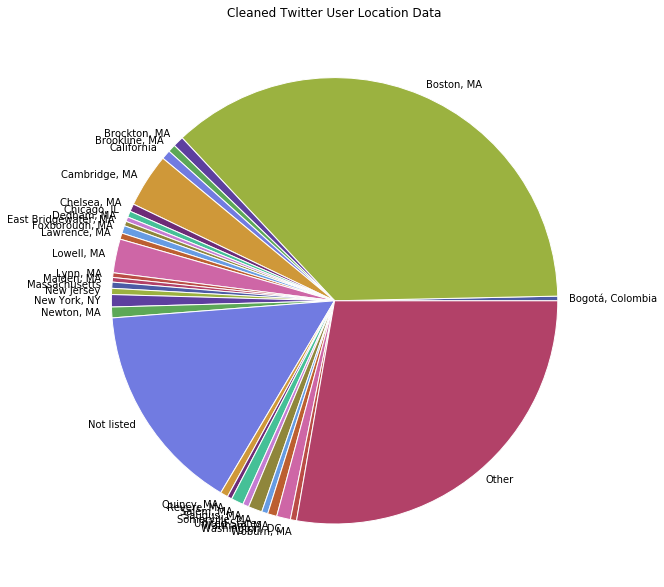

In [22]:
#Create a pie chart of twitter users stated location
# Create a list of colors (from iWantHue)
colors = ["#4c5ba5",
"#9bb240",
"#5d3f9f",
"#5ca857",
"#717be1",
"#cf9839",
"#6d2b77",
"#45c097",
"#c57cd3",
"#8f863b",
"#669ce3",
"#bc5f30",
"#ce66a6",
"#ba4c46",
"#b24168"]

# Create a pie chart

fig = plt.figure(figsize=[10, 10])
ax = fig.add_subplot(111)

cleanpie = ax.pie(df_count_cleaned['Count'], labels=df_count_cleaned.index.get_values(), shadow=False, colors=colors, labeldistance=1.05)

for slice in cleanpie[0]:
    slice.set_edgecolor('white')
    
ax.set_title ('Cleaned Twitter User Location Data')

cleanpie

In [23]:
# Create a filter from df_tweets filtering only those that have values for lat and lon
df_tweets_with_location = df_tweets[df_tweets.lon.notnull() & df_tweets.lat.notnull()]
df_tweets_with_location

,tweet_id,lat,lon,content,location,user,raw_source,data_point,time,location2
838948458631319552,838948458631319552,-71.2356,42.3765,"Interested in a #job in #Waltham, MA? This cou...","Boulder, CO",3562102752,"{'id_str': '838948458631319552', 'entities': {...",none,Tue Mar 07 03:04:34 +0000 2017,"Boulder, CO"
838950726319636484,838950726319636484,-71.0611,42.2837,"Opened report via iphone at 37 Carruth St, Dor...","Boston, MA",3413390356,"{'id_str': '838950726319636484', 'entities': {...",none,Tue Mar 07 03:13:34 +0000 2017,"Boston, MA"


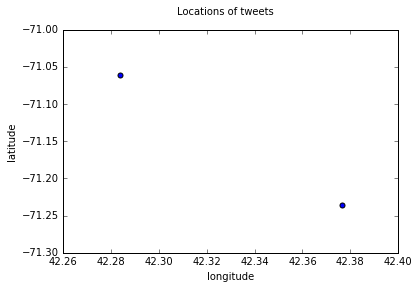

In [24]:
#Create scatterplot of lat / long of tweets
plt.scatter(df_tweets_with_location['lon'],df_tweets_with_location['lat'], s=25)
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.suptitle('Locations of tweets')
plt.show()


In [26]:
#Export to CSV
df_tweets.to_csv('twitter_data_blank2.csv',sep=',', encoding='utf-8')

# Scrape more tweets!
This time, I will scrape tweets about women with the intent to capture some of the conversations on the night before International Women's Day. 

In [ ]:
#Scrape some more tweets!

search_term='women' # SETS THE SEARCH TERM

#modify the get_lots_of_tweets function to only scrape 15 minutes of tweets
def get_lots_of_tweets( latlong ):
    # Create a dictionary to parse the JSON
    all_tweets = {}
    
    # Hit the API for total of 900 seconds, ie 15 minutes
    total_time = 900
    
    # Everytime we hit the API we subtract time from the total
    remaining_seconds = total_time
    interval = 60
    while remaining_seconds > 0: # loop and run the function while remaining seconds is greater than zero
        added = 0
        # Hit the Twitter API using our function
        new_tweets = get_tweets_by_location(latlong) # we set latlong above!
        # Parse the resulting JSON, and save the rest of the raw content
        for tweet in new_tweets:
            tid = tweet['id']
            if tid not in all_tweets:
                properties = {}
                if tweet['coordinates'] != None:
                    properties['lat'] = tweet['coordinates']['coordinates'][0]
                    properties['lon'] = tweet['coordinates']['coordinates'][1]
                else:
                    properties['lat'] = None
                    properties['lon'] = None
                properties['location'] = tweet['user']['location'] #This will get us the location associated with the profile
                properties['tweet_id'] = tid
                properties['content'] = tweet['text']
                properties['user'] = tweet['user']['id']
                properties['raw_source'] = tweet
                properties['data_point'] = 'none'
                properties['time'] = tweet['created_at']
                all_tweets[ tid ] = properties
                added += 1
        print("At %d seconds, added %d new tweets, for a total of %d" % ( total_time - remaining_seconds, added, len( all_tweets )))
        # We wait a few seconds and hit the API again
        time.sleep(interval)
        remaining_seconds -= interval
    print(str(len(all_tweets)) + ' Tweets retrieved.')
    # We return the final dictionary to work with in Python
    return all_tweets

run_all()


In [18]:
file_dir2 = "data/women" # moved json so it doesn't read-in tweets from previous scrape

# Get get the JSON
onlyfiles = [ f for f in listdir(file_dir2) if isfile(join(file_dir2,f)) and not f.startswith('.')]

# create an new, empty dataframe with columns for each property
df_tweets2 = pd.DataFrame(columns = ['tweet_id', 'lat', 'lon', 'content','location','user','raw_source','data_point','time'])

# Loop through all the files
for file in onlyfiles:
    full_dir = join(file_dir2,file) 
    with open(full_dir) as json_data:
        dict = json.load(json_data) # creates a Python dictionary of our json
        if not isinstance(dict, list):
            for key, val in dict.items():
                df_tweets2.loc[key,val] = val
                

In [19]:
#check for duplicates in user_id...
df_tweets2[df_tweets2['tweet_id'].duplicated()]

,tweet_id,lat,lon,content,location,user,raw_source,data_point,time


In [26]:
#check for variations in location... 
len(df_tweets2['location'].unique())

64

In [23]:
boston = ['South End, Boston','Boston,MA','UMass Boston','Brighton, MA','Boston - MA','Boston, Massachusetts','Bean-Town/Salem World','Boston, MA','Boston', 'Boston ','boston  ','Boston, USA','Boston,MA.','Boston MA','Dorchester MA', 'Boston Massachusetts','boston','Boston, Ma.','Boston/Brockton','Boston Ma ','boston, ma','E. Bridgewater, MA/Boston, MA','Boston,Ma','Boston, MA & Jamaica ','Kolter Lab, Boston, MA','Boston. Taunton.','boston ','Boston University ','South Boston ➡️⬅️Gillette ','Boston College','Boston, Ma','100 Legends Way Boston, MA','Boston, MA & Drakes Island, ME','Boston Bruins','WestSide, Boston 32Ave','South Boston','  Boston ','Boston Ma','Suffolk University','Boston, Ma.  USA','Dorchester, Mass','BOS']

cambridge = ['Cambridge, Massachusetts','Harvard University','Harvard Law School','ハーバード大学','Cambridge MA','cambridge, ma']

nyc = ['Manhattan, NY','New York, New York','New York City']


df_tweets2['location2']=df_tweets2['location']
df_tweets2['location2']=df_tweets2['location2'].replace(boston, 'Boston, MA')
df_tweets2['location2']=df_tweets2['location2'].replace(cambridge, 'Cambridge, MA')
df_tweets2['location2']=df_tweets2['location2'].replace(nyc, 'New York, NY')



In [27]:
#check cleaned # of locations
len(df_tweets2['location2'].unique())

55

In [25]:
#Export to csv
df_tweets2.to_csv('twitter_data_women.csv', sep=',', encoding='utf-8')